In [1]:
import os
#import re
import sys
#import json
import glob
import random
#import pickle
import subprocess
from datetime import datetime
from collections import Counter
from joblib import Parallel, delayed

import numpy
import pandas as pd

from nltk.corpus import stopwords as sw

import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
#from sklearn import metrics

from pynlpl.formats import folia

# Customs
#import get_folia_tokens as gft

%matplotlib inline

In [2]:
def getAnnotatedDocs(inputfolder='../EIFD/data/EIFD-FlatData', foliaset='https://raw.githubusercontent.com/ErkanBasar/mebasarcom/master/eifd.foliaset.xml'):
    return [xfile for xfile in glob.glob(inputfolder +'/*.folia.xml') if folia.Document(file=xfile).declared(folia.Entity, foliaset)]

In [3]:
annotdocs = getAnnotatedDocs()

## Feature Extraction

In [4]:
notstop = ['this', 'until', 'about', 'above' , 'over' , 'under' , 'more', 'some', 'few', 'than', 'now', 'at']
stopwords = [word for word in sw.words('english') if word not in notstop]
#ignored = ['dmg.ppl.inj', 'dmg.ppl.miss', 'dmg.bus', 'dmg.econ', 'loc.other']

In [5]:
class Token(object):
    
    def __init__(self, folia_obj):
        self.obj = folia_obj
        self.cls = 'O'
        self.ner = '---'
        self.htime = '---'
        self.previous = None
        self.next = None
        self.get_entities()
        if(self.obj is None):
            self.foliaId = '---'
            self.text = '---'
            self.pos = '---'
        else:
            self.foliaId = self.obj.id
            self.text = self.obj.text()
            self.pos = self.obj.pos()

    def getClass(self, classes):
        if(self.obj is not None):
            for entity in self.obj.findspans(folia.Entity):
                if(entity.annotatortype == folia.AnnotatorType.MANUAL):
                    if(entity.cls in classes):
                        if(entity.cls == 'loc.other'):
                            entityclass = entity.cls #'loc.focus' 
                        else:
                            entityclass = entity.cls 
                        self.cls = 'B.' + entityclass
                        if(self.previous == None):
                            self.cls = 'B.' + entityclass 
                        else:
                            for prevEntity in self.previous.findspans(folia.Entity):
                                if(entity.id == prevEntity.id and prevEntity.annotatortype == folia.AnnotatorType.MANUAL):
                                    self.cls = 'I.' + entityclass
        return self.cls
    
    def get_entities(self):
        if(self.obj is not None):
            for entity in self.obj.findspans(folia.Entity):
                if(entity.annotator == 'nltk-stanford'):
                    self.sner = entity.cls
                elif(entity.annotator == 'heidel-time'):
                    self.htime = entity.cls
    
    def getPrevious(self):
        if self.obj is not None and self.obj.previous(folia.Word, [folia.Sentence]) is not None:
            self.previous = self.obj.previous(folia.Word, [folia.Sentence])
        return self.previous
    
    def getNext(self):
        if self.obj is not None and self.obj.next(folia.Word, [folia.Sentence]) is not None:
            self.next = self.obj.next(folia.Word, [folia.Sentence])
        return self.next
    
    def kill(self):
        del self

In [6]:
def create_line(token, classes, sliding=False):
    prevToken = Token(token.getPrevious())
    nextToken = Token(token.getNext())
    previous_of_next_token = Token(nextToken.getPrevious())
    previous_of_previous_token = Token(prevToken.getPrevious())
    currentClass = str(token.getClass(classes))
    if(prevToken.text == "---"):
        prevClass = "---"
    else:
        prevClass = str(prevToken.getClass(classes))   
    if(nextToken.text == "---"):
        nextClass = "---"
    else:
        nextClass = str(nextToken.getClass(classes))
    line = token.text + ' ' + token.pos + ' ' + token.ner + ' ' + token.htime + ' '
    if(sliding):
        line = line + prevClass + '|' + currentClass + '|' + nextClass + '\n'
    else:
        line = line + currentClass + '\n'
    return line

In [7]:
def create_mbt_file(filelist, outfilepath, classes, sliding=False):
    filelist = [filelist] if(type(filelist) == str) else filelist
    if(type(filelist) == list and len(filelist) >= 1):
        outfile = open(outfilepath, 'w')
        for filepath in filelist:
            for doc in folia.Document(file=filepath):
                for sentence in doc.sentences():
                    for word in sentence.words():
                        token = Token(word)
                        outfile.write(create_line(token, classes, sliding))
                    outfile.write('<utt>\n')
        outfile.close()
    else:
        print('Input may be wrong. It should be a list of file paths or a single string file path.')
        print('Input type you tried: ' + str(type(filelist)))
        sys.exit()

# Article Cross-validater

In [8]:
def get_cv_chunks(doclist, n, shuffle=True):
    if(shuffle):
        random.shuffle(doclist)
    return [doclist[i:i + n] for i in range(0, len(doclist), n)]

In [9]:
def split_per_chunk(cv_label_folder, classes, doclist, testdocs, i, sliding=False):
    traindocs = [doc for doc in doclist if doc not in testdocs]
    os.makedirs(os.path.dirname(cv_label_folder + '/CV_' + str(i) + '/'), exist_ok=True)
    create_mbt_file(traindocs, cv_label_folder + '/CV_' + str(i) + '/MBTTrain_cv' + str(i) + '.data', classes, sliding)
    create_mbt_file(testdocs, cv_label_folder + '/CV_' + str(i) + '/MBTTest_cv' + str(i) + '.data', classes, sliding)

In [10]:
def create_cv_files(cv_label_folder, cv_chunks, doclist, classes, sliding=False):
    Parallel(n_jobs=-2)(delayed(split_per_chunk)(cv_label_folder, classes, doclist, testdocs, i, sliding) for i, testdocs in enumerate(cv_chunks))

## Run MBT

In [11]:
def run_on_single_chunk(cv_label_folder, label_folder, k, known_words, unknown_words):
    i = label_folder.split('CV_')[1]
    p = subprocess.Popen(['mbtg', '-E', 'MBTTrain_cv' + str(i) + '.data', '-p', known_words, '-P', unknown_words, '-O-k' + str(k) + ''], 
                         cwd=cv_label_folder + '/CV_' + str(i) + '/')
    p.wait()
    testOut = open(cv_label_folder + '/CV_' + str(i) + '/test_cv' + str(i) + '.out', 'w') 
    p = subprocess.Popen(['mbt', '-s', 'MBTTrain_cv' + str(i) + '.data.settings', '-E','MBTTest_cv' + str(i) + '.data', '-O-k' + str(k) + ''], 
                         stdout=testOut, cwd=cv_label_folder + '/CV_' + str(i) + '/')
    p.wait()

In [12]:
def run_mbt(cv_label_folder, k=3, known_words='dwdwfWawaw', unknown_words='cndwdwFawaw'):
    Parallel(n_jobs=-2)(delayed(run_on_single_chunk)(cv_label_folder, label_folder, k, known_words, unknown_words) for label_folder in glob.glob(cv_label_folder +'/CV_*'))

# Evaluation

In [13]:
def conll_tag(tag):
    if(tag is not 'O'):
        tagsplt = tag.split('.')
        IOB = tagsplt[0]
        del tagsplt[0]
        rest = '_'.join(tagsplt)
        tag = IOB + '-' + rest
    return tag

In [14]:
def majority_voting(combined_tag1, combined_tag2, combined_tag3):
    prev = combined_tag1.split('|')[2]
    curr = combined_tag2.split('|')[1]
    nextg = combined_tag3.split('|')[0]
    if(prev == nextg):
        decidedtag = prev
    else:
        decidedtag = curr
    return decidedtag

In [15]:
def merged_cv_evaluation(cv_label_folder, sliding=False):
    outfile = open(cv_label_folder + '/test.out', 'w')
    for label_folder in glob.glob(cv_label_folder +'/CV_*'):
        i = label_folder.split('CV_')[1]
        testOut = open(label_folder + '/test_cv' + str(i) + '.out', 'r')
        outcv = open(label_folder + '/testconll_cv' + str(i) + '.out', 'w')
        lines = testOut.readlines()
        ulines = lines[7:]
        for i,line in enumerate(ulines):
            if(sliding):
                prev_line = ulines[i-1] if i > 0 else "Token	/	--- --- ---	---|---|---	---|---|---"              
                prev_splt = prev_line.split('\n')[0].split('\t')
                prev_pred = prev_splt[-1] if len(prev_splt) > 1 else "---|---|---"
                next_line = ulines[i+1] if i != len(ulines)-1 else "Token	/	--- --- ---	---|---|---	---|---|---"
                next_splt = next_line.split('\n')[0].split('\t')
                next_pred = next_splt[-1] if len(next_splt) > 1 else "---|---|---"
            tabsplt = line.split('\n')[0].split('\t')
            if(len(tabsplt) > 1):
                if(sliding):
                    Y = tabsplt[-2].split('|')[1]
                    curr_pred = tabsplt[-1]
                    P = majority_voting(prev_pred, curr_pred, next_pred)
                else:
                    Y = tabsplt[-2]
                    P = tabsplt[-1]
                line = tabsplt[0] + ' ' + conll_tag(Y) + ' ' + conll_tag(P) + '\n'
                outcv.write(line)
                outfile.write(line)
            else:
                outcv.write('\n')
                outfile.write('\n')
        outcv.close()        
        testOut.close()
        outfile.write('\n')
    outfile.close()
    os.system('perl conlleval.pl <' + cv_label_folder + '/test.out >' + cv_label_folder + '/eval.out')

In [16]:
def read_eval_scores(cv_label_folder):
    testeval = open(cv_label_folder + '/eval.out', 'r')
    scores = {}
    for line in testeval:
        info = list(filter(lambda a: a != '', line.split(' ')))
        if('processed' in info):
            continue
        elif('accuracy:' in info):
            scores['average'] = {}
            scores['average']['accuracy'] = float(info[1].split('%')[0])
            scores['average']['precision'] = float(info[3].split('%')[0])
            scores['average']['recall'] = float(info[5].split('%')[0])
            scores['average']['f1-score'] = float(info[7].split('\n')[0])
        else:
            label = info[0].split(':')[0]
            scores[label] = {}
            scores[label]['precision'] = float(info[2].split('%')[0])
            scores[label]['recall'] = float(info[4].split('%')[0])
            scores[label]['f1-score'] = float(info[6])
            scores[label]['support'] = int(info[7].split('\n')[0])
    return scores

In [17]:
def evaluation_report(scores):
    print(pd.DataFrame(scores).T.reindex_axis(["precision", "recall", "f1-score"], axis=1))

In [18]:
def draw_prf1_bar(scores, cv_label_folder, title='Scores by Label'):
    precision = []
    recall = []
    f1_score = []
    labels = []
    for s in sorted(scores.items()):
        labels.append(s[0])
        precision.append(s[1]['precision'])
        recall.append(s[1]['recall'])
        f1_score.append(s[1]['f1-score'])
    index = np.arange(len(labels))
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    bar_width = 0.25
    opacity = 1
    ax.bar(index, precision, bar_width, color='b', label='Precision', alpha=opacity, zorder=3)
    ax.bar(index + bar_width, recall, bar_width, color='m', label='Recall', alpha=opacity, zorder=3)
    ax.bar(index + (2*bar_width), f1_score, bar_width, color='c', label='F1-score', alpha=opacity, zorder=3)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labels, rotation=75)
    ax.set_ylim([0,100])
    ax.grid(zorder=0)
    ax.legend()
    plt.xlabel('Labels')
    plt.ylabel('Scores (%)')
    plt.title(title)
    plt.show()
    fig.savefig(cv_label_folder + '/BarChart.png')

In [19]:
def print_results(cv_label_folder, title='Scores by Label', binary=False, classes=None):
    if(binary):
        scores = {}
        for cls in binary_classes:
            cls_ = '_'.join(cls.split('.'))
            scores[cls_] = read_eval_scores(cv_label_folder + cls)[cls_]
    else:
        scores = read_eval_scores(cv_label_folder)
    if('average' in list(scores)):
        del scores['average']
    evaluation_report(scores)
    draw_prf1_bar(scores, cv_label_folder, title)

In [20]:
def get_flat_results(cv_label_folder):
    testOut = open(cv_label_folder + '/test.out', "r")
    lines = testOut.readlines()
    Y = []
    predictions = []
    for line in lines:
        tabsplt = line.split("\n")[0].split(" ")
        if(len(tabsplt) > 1):
            Y.append(tabsplt[-2])
            predictions.append(tabsplt[-1])
    testOut.close()
    return Y, predictions

In [21]:
def confusion_matrix(cv_label_folder):
    Y, P = get_flat_results(cv_label_folder)
    uniquelist = sorted([label for label in list(set(Y))])
    Yint = [sorted(uniquelist).index(item) for item in Y]
    Pint = [sorted(uniquelist).index(item) for item in P]
    skplt.plot_confusion_matrix(Yint, Pint, normalize=True, figsize=(12,12))
    plt.show()

# Main

In [22]:
def main(cv_label_folder, cv_chunks, doclist, classes, sliding=False, k=3):
    create_cv_files(cv_label_folder, cv_chunks, doclist, classes, sliding)
    run_mbt(cv_label_folder, k)
    merged_cv_evaluation(cv_label_folder, sliding)

In [23]:
mbt_folder = 'data/MBTData/'
folder_sliding = mbt_folder + 'Cross-validated/Sliding/'
folder_slidinggg = mbt_folder + 'Cross-validated/Sliding3/'
folder_final = mbt_folder + 'Cross-validated/Final1/'
folder_finalll = mbt_folder + 'Cross-validated/Final3/'

# Initialize Chunks

In [25]:
cv_chunks = get_cv_chunks(annotdocs, 1)

# 4 Major Classes

In [26]:
major_classes = ['event.flood', 'loc.focus', 'loc.supp', 'time']

             precision  recall  f1-score
event_flood      56.08   36.30     44.07
loc_focus        42.03   14.72     21.80
loc_supp         56.82   24.75     34.48
time             17.65    6.25      9.23


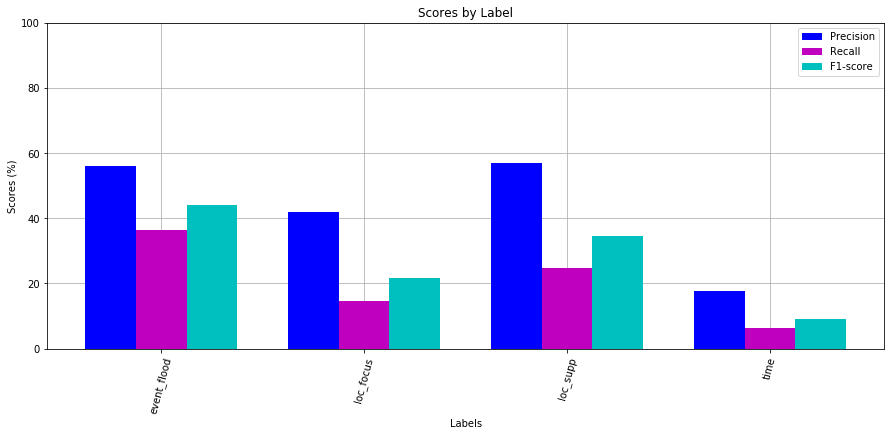

In [57]:
print_results(folder_finalll + 'major_classes')

             precision  recall  f1-score
event_flood      49.07   36.30     41.73
loc_focus        40.32   25.38     31.15
loc_supp         49.21   30.69     37.80
time             25.93   14.58     18.67


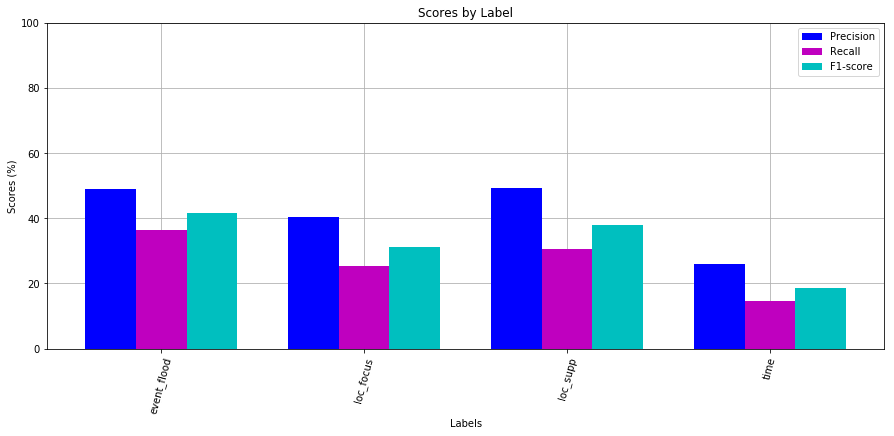

In [176]:
print_results(folder_final + 'major_classes')

             precision  recall  f1-score
event_flood      43.17   20.55     27.84
loc_focus        32.76    9.64     14.90
loc_supp         37.50   14.85     21.28
time             20.00    6.25      9.52


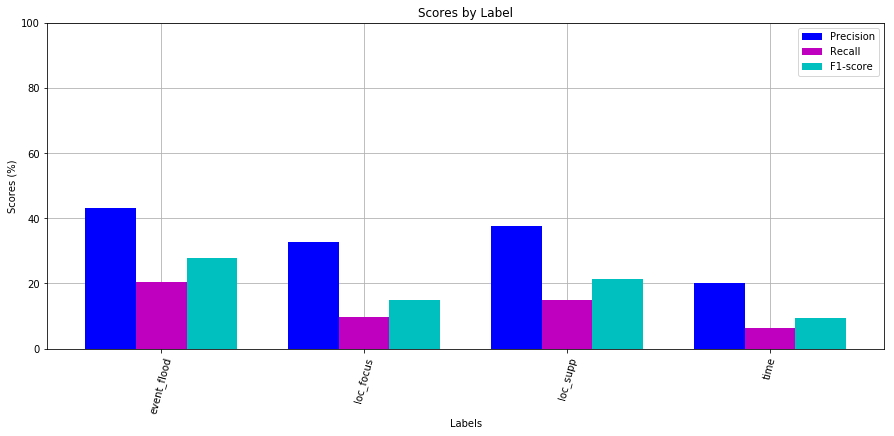

In [177]:
print_results(folder_sliding + 'major_classes')

# All Classes

In [60]:
all_classes = ['event.flood', 'loc.focus', 'loc.supp', 'time', 'dmg.ppl.evac', 
               'dmg.ppl.kill', 'dmg.prop', 'resp.donat', 'resp.supply']

In [61]:
main(folder_finalll + 'all_classes', cv_chunks, annotdocs, all_classes, sliding=False)

              precision  recall  f1-score
dmg_ppl_evac       0.00    0.00      0.00
dmg_ppl_kill      22.22    4.30      7.21
dmg_prop          34.62   12.86     18.75
event_flood       57.47   34.25     42.92
loc_focus         42.67   16.24     23.53
loc_supp          57.14   23.76     33.57
resp_donat        52.94   40.91     46.15
resp_supply       16.67    4.40      6.96
time              25.93    7.29     11.38


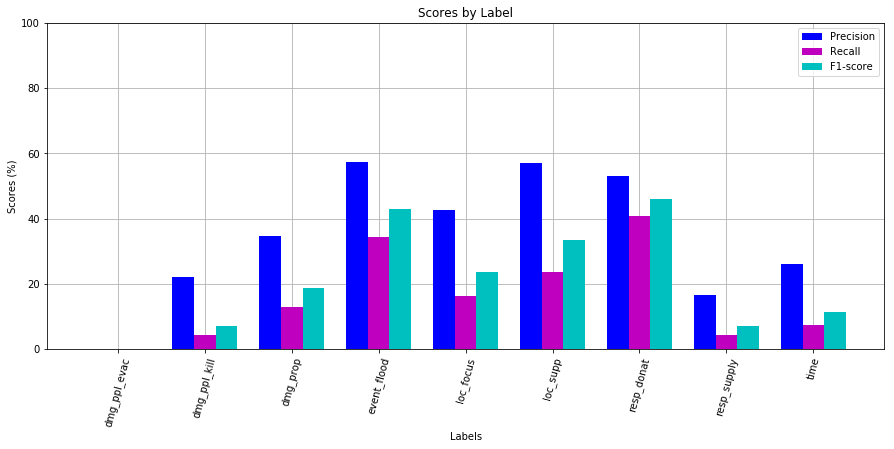

In [62]:
print_results(folder_finalll + 'all_classes')

              precision  recall  f1-score
dmg_ppl_evac      16.00    9.09     11.59
dmg_ppl_kill      24.14   15.05     18.54
dmg_prop          13.95    8.57     10.62
event_flood       50.24   35.27     41.45
loc_focus         37.40   23.35     28.75
loc_supp          45.90   27.72     34.57
resp_donat        30.77   18.18     22.86
resp_supply        8.77    5.49      6.76
time              32.76   19.79     24.68


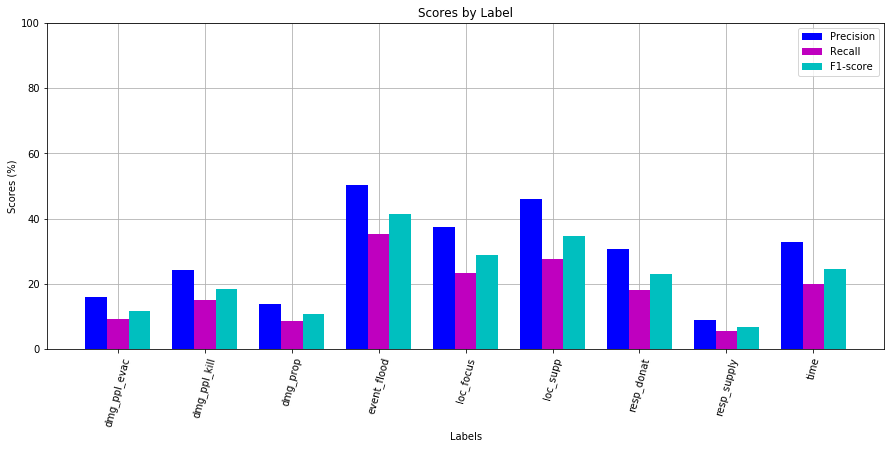

In [179]:
print_results(folder_final + 'all_classes')

              precision  recall  f1-score
dmg_ppl_evac      23.08    6.82     10.53
dmg_ppl_kill      45.16   15.05     22.58
dmg_prop          13.04    4.29      6.45
event_flood       40.91   18.49     25.47
loc_focus         30.61    7.61     12.20
loc_supp          35.14   12.87     18.84
resp_donat        14.29    4.55      6.90
resp_supply       10.34    3.30      5.00
time              20.69    6.25      9.60


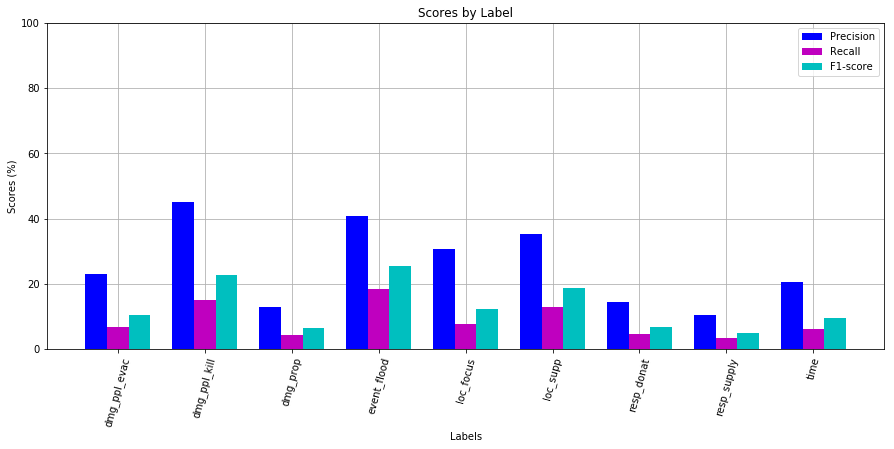

In [180]:
print_results(folder_sliding + 'all_classes')

# Binary Classifiers 

In [63]:
binary_classes = ['event.flood', 'loc.focus', 'loc.supp', 'time', 'dmg.ppl.evac', 
                  'dmg.ppl.kill', 'dmg.prop', 'resp.donat', 'resp.supply']

In [64]:
for cls in binary_classes:
    print(cls)
    main(folder_finalll + 'Binaries/' + cls, cv_chunks, annotdocs, [cls], sliding=False)

event.flood
loc.focus
loc.supp
time
dmg.ppl.evac
dmg.ppl.kill
dmg.prop
resp.donat
resp.supply


              precision  recall  f1-score
dmg_ppl_evac       0.00    0.00      0.00
dmg_ppl_kill      21.43    6.45      9.92
dmg_prop          30.30   14.29     19.42
event_flood       55.61   39.04     45.88
loc_focus         37.08   16.75     23.08
loc_supp          50.00   26.73     34.84
resp_donat        38.89   31.82     35.00
resp_supply       23.68    9.89     13.95
time              13.95    6.25      8.63


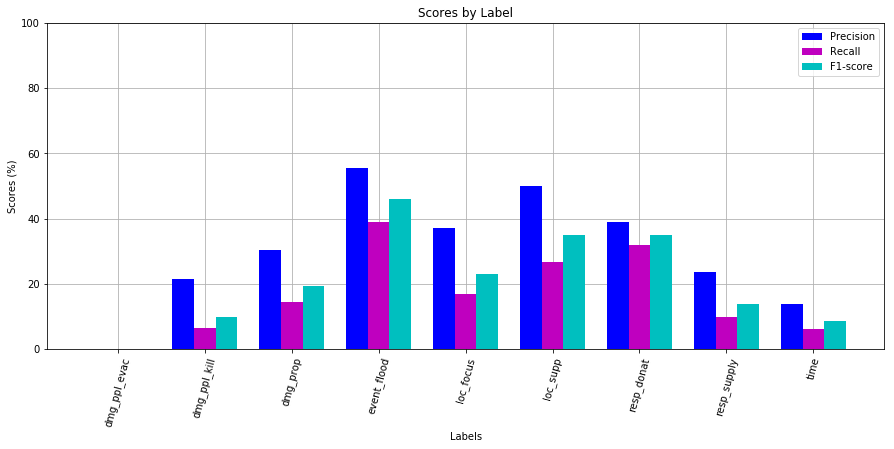

In [65]:
print_results(folder_finalll + 'Binaries/', binary=True, classes=binary_classes)

              precision  recall  f1-score
dmg_ppl_evac      15.00    6.82      9.38
dmg_ppl_kill      30.36   18.28     22.82
dmg_prop          15.38    8.57     11.01
event_flood       47.58   36.99     41.62
loc_focus         31.90   18.78     23.64
loc_supp          39.24   30.69     34.44
resp_donat        37.50   27.27     31.58
resp_supply       18.87   10.99     13.89
time              24.14   14.58     18.18


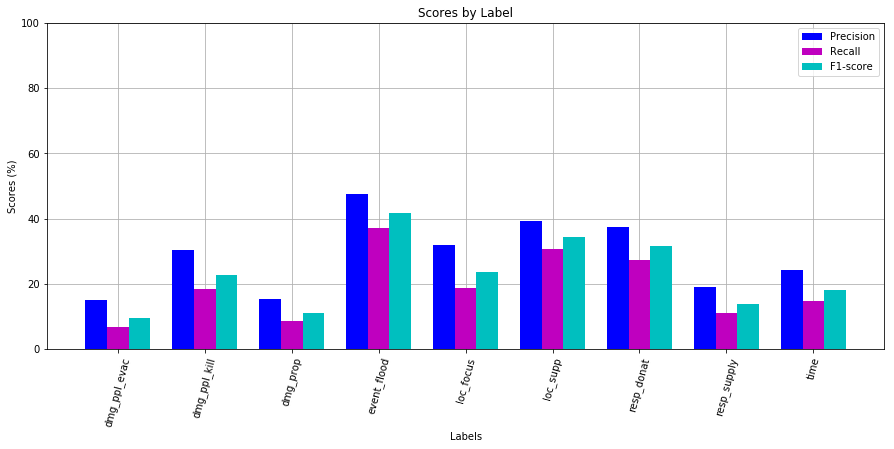

In [181]:
print_results(folder_final + 'Binaries/', binary=True, classes=binary_classes)

              precision  recall  f1-score
dmg_ppl_evac       0.00    0.00      0.00
dmg_ppl_kill      44.74   18.28     25.95
dmg_prop          14.29    4.29      6.59
event_flood       46.84   25.34     32.89
loc_focus         39.29   16.75     23.49
loc_supp          47.54   28.71     35.80
resp_donat         0.00    0.00      0.00
resp_supply        0.00    0.00      0.00
time              16.67    9.38     12.00


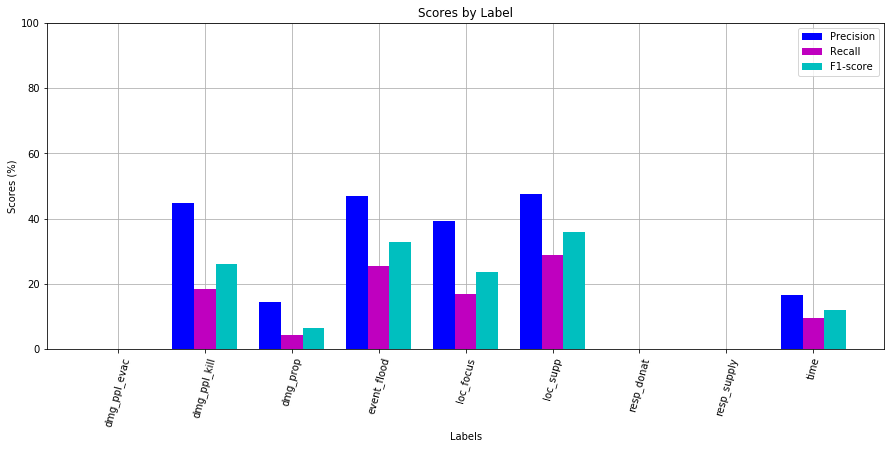

In [182]:
print_results(folder_sliding + 'Binaries/', binary=True, classes=binary_classes)

### Confusion Matrixes

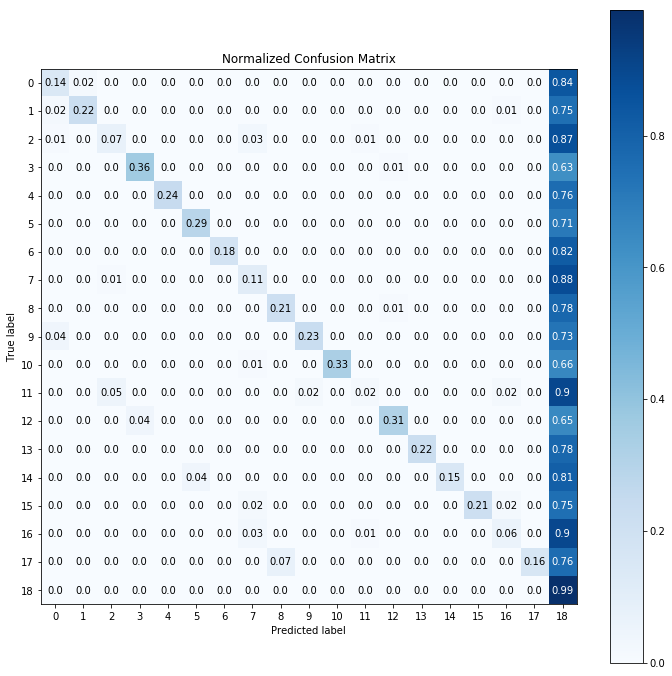

In [93]:
confusion_matrix(folder_final + 'all_classes')

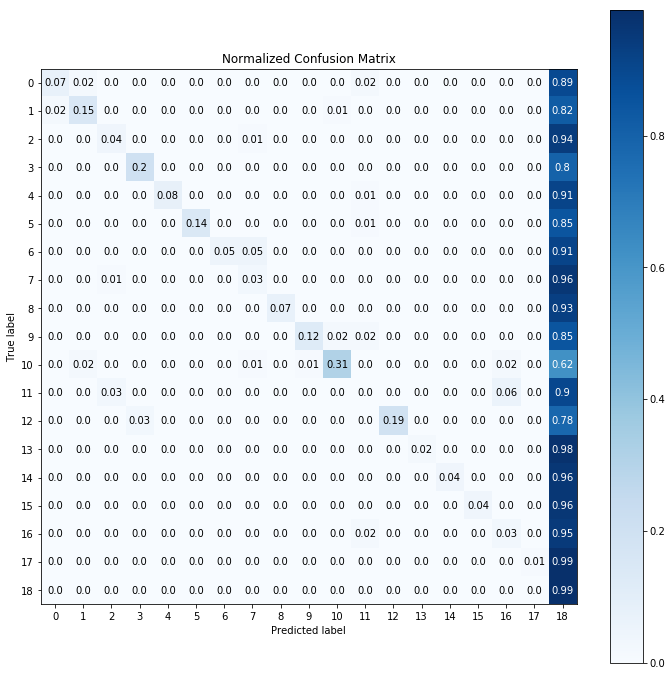

In [95]:
confusion_matrix(folder_sliding + 'all_classes')